# ML for CS Project: Malware Detection netML Leaderboard Result Reproduction

**Team:** Rhea Madhogarhia, Anushka Agarwal, Rohan Madhogarhia

## Project Summary
The goal of this project is to determine whether we can train a model to detect malware flows in a network. Effective malware detection helps protect systems and users from security threats. We aim to reproduce and potentially improve upon the results of the netML malware detection leaderboard.

## Objectives
1.  **Data Analysis:** Understand the netML dataset and check for class imbalances.
2.  **Model Training:** Experiment with Random Forest, CatBoost, XGBoost, and KNN.
3.  **Evaluation:** Focus on Recall/Sensitivity to minimize false negatives (malware slipping through).

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import pyshark

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Advanced Boosting Libraries
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not installed. Skipping import.")

try:
    from catboost import CatBoostClassifier
except ImportError:
    print("CatBoost not installed. Skipping import.")

# Set visualization style
sns.set(style="whitegrid")

## 1. Data Loading

Load the dataset from the netML leaderboard. 
*Note: Ensure the data file is in the same directory or update the path below.*

Code to convert our netml dataset into a pandas dataframe

### 1a. Load data

In [52]:
from scapy.all import PcapNgReader, Ether, IP, UDP
import pandas as pd

def packet_to_row(pkt, max_raw_len=120):
    row = {
        "timestamp": pkt.time,
        "pkt_len": len(pkt),
    }

    # --- Ethernet layer ---
    if Ether in pkt:
        eth = pkt[Ether]
        row.update({
            "eth_dst": eth.dst,
            "eth_src": eth.src,
            "eth_type": eth.type,
        })

    # --- IP layer ---
    if IP in pkt:
        ip = pkt[IP]
        row.update({
            "ip_version": ip.version,
            "ip_ihl": ip.ihl,
            "ip_tos": ip.tos,
            "ip_len": ip.len,
            "ip_id": ip.id,
            "ip_flags": int(ip.flags),  # make flags numeric
            "ip_frag": ip.frag,
            "ip_ttl": ip.ttl,
            "ip_proto": ip.proto,
            "ip_chksum": ip.chksum,
            "ip_src": ip.src,
            "ip_dst": ip.dst,
            "ip_options_len": len(ip.options) if ip.options is not None else 0,
        })

    # --- UDP layer ---
    if UDP in pkt:
        udp = pkt[UDP]
        row.update({
            "l4_proto": "UDP",
            "udp_sport": udp.sport,
            "udp_dport": udp.dport,
            "udp_len": udp.len,
            "udp_chksum": udp.chksum,
        })
    else:
        row["l4_proto"] = None

    # --- Raw payload (truncated, decoded) ---
    if pkt.haslayer("Raw"):
        raw = pkt["Raw"].load
        truncated = raw[:max_raw_len]
        try:
            row["raw_load"] = truncated.decode("utf-8", errors="replace")
        except Exception:
            row["raw_load"] = repr(truncated)
    else:
        row["raw_load"] = None

    return row

rows = []
with PcapNgReader("data/traffic.pcapng") as pcap_reader:
    for pkt in pcap_reader:
        rows.append(packet_to_row(pkt))

df = pd.DataFrame(rows)
df.head()


,timestamp,pkt_len,eth_dst,eth_src,eth_type,ip_version,ip_ihl,ip_tos,ip_len,ip_id,...,ip_chksum,ip_src,ip_dst,ip_options_len,l4_proto,udp_sport,udp_dport,udp_len,udp_chksum,raw_load
0,2419462452.933651,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,64595,...,2757,192.168.1.103,239.255.255.250,0,UDP,54812.0,1900.0,183.0,36797.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...
1,2419466747.912463,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,37500,...,29852,192.168.1.103,239.255.255.250,0,UDP,54812.0,1900.0,183.0,36797.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...
2,2419471042.882392,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,51748,...,15604,192.168.1.103,239.255.255.250,0,UDP,54812.0,1900.0,183.0,36797.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...
3,2419475337.90648,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,39014,...,28338,192.168.1.103,239.255.255.250,0,UDP,54812.0,1900.0,183.0,36797.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...
4,894306680.3797,216,01:00:5e:7f:ff:fa,c0:38:96:11:73:e5,2048,4,5,0,202,10258,...,57038,192.168.1.160,239.255.255.250,0,UDP,54334.0,1900.0,182.0,27627.0,M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250:1...


### 1b. Create Features

In [53]:
df.shape
df.columns

import numpy as np
import pandas as pd
import ipaddress

def is_private_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except Exception:
        return np.nan

def is_multicast_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_multicast
    except Exception:
        return np.nan

def add_packet_features(df):
    df = df.copy()

    # Ensure timestamp is datetime (if not already)
    if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='ignore')

    # ---- Basic sizes ----
    # UDP header is 8 bytes; payload_len >= 0
    df['payload_len'] = np.where(df['udp_len'].notna(),
                                 np.maximum(df['udp_len'] - 8, 0),
                                 np.nan)

    # raw payload length (works whether it's bytes or str; NaN -> 0)
    df['raw_len'] = df['raw_load'].apply(
        lambda x: len(x) if isinstance(x, (bytes, bytearray, str)) else 0
    )

    # ---- Port-based features ----
    # use udp_dport as generic dport since your dataset is UDP
    df['dport'] = df['udp_dport']
    df['sport'] = df['udp_sport']

    df['dport_is_well_known'] = df['dport'] < 1024
    df['dport_is_high'] = df['dport'] >= 1024

    common_ports = {
        53: 'dns',
        80: 'http',
        443: 'https',
        22: 'ssh',
        123: 'ntp',
        1900: 'ssdp',
    }
    df['dport_service'] = df['dport'].map(common_ports).fillna('other')

    # one-hot-ish: is_dns, is_http, etc
    df['is_dns'] = (df['dport'] == 53)
    df['is_http'] = (df['dport'] == 80)
    df['is_https'] = (df['dport'] == 443)
    df['is_ssdp'] = (df['dport'] == 1900)

    # ---- IP features ----
    df['ip_src_private'] = df['ip_src'].apply(is_private_ip)
    df['ip_dst_private'] = df['ip_dst'].apply(is_private_ip)
    df['ip_src_multicast'] = df['ip_src'].apply(is_multicast_ip)
    df['ip_dst_multicast'] = df['ip_dst'].apply(is_multicast_ip)

    # internal -> external, external -> internal, internal <-> internal, etc.
    def flow_direction(row):
        sp = row['ip_src_private']
        dp = row['ip_dst_private']
        if sp and not dp:
            return 'internal_to_external'
        elif not sp and dp:
            return 'external_to_internal'
        elif sp and dp:
            return 'internal_to_internal'
        elif not sp and not dp:
            return 'external_to_external'
        return 'unknown'

    df['direction'] = df.apply(flow_direction, axis=1)

    # TTL and packet size normalized-ish features
    df['ttl'] = df['ip_ttl']
    df['ttl_is_low'] = df['ttl'] <= 5  # good for detecting local/multicast chatter
    df['pkt_size'] = df['pkt_len']

    # ---- Payload "shape" features ----
    # Very cheap “is this mostly ascii?” heuristic
    def is_mostly_ascii(x):
        if isinstance(x, (bytes, bytearray)):
            b = x
        elif isinstance(x, str):
            b = x.encode('utf-8', errors='ignore')
        else:
            return False
        if len(b) == 0:
            return False
        printable = sum(32 <= c < 127 for c in b)
        return printable / len(b) > 0.8

    df['payload_mostly_ascii'] = df['raw_load'].apply(is_mostly_ascii)

    # e.g., HTTP-ish text detection (even in UDP, for weird stuff)
    df['payload_contains_http'] = df['raw_load'].apply(
        lambda x: ('HTTP/' in x if isinstance(x, str) else
                   (b'HTTP/' in x if isinstance(x, (bytes, bytearray)) else False))
    )

    return df

df_features = add_packet_features(df)
df_features.head()


# extract features

/var/folders/zx/5gx8nw1j6bg4lvdv3ws19cnh0000gn/T/ipykernel_57700/3261666433.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='ignore')


,timestamp,pkt_len,eth_dst,eth_src,eth_type,ip_version,ip_ihl,ip_tos,ip_len,ip_id,...,ip_src_private,ip_dst_private,ip_src_multicast,ip_dst_multicast,direction,ttl,ttl_is_low,pkt_size,payload_mostly_ascii,payload_contains_http
0,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,64595,...,True,False,False,True,internal_to_external,1,True,217,True,True
1,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,37500,...,True,False,False,True,internal_to_external,1,True,217,True,True
2,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,51748,...,True,False,False,True,internal_to_external,1,True,217,True,True
3,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,39014,...,True,False,False,True,internal_to_external,1,True,217,True,True
4,None,216,01:00:5e:7f:ff:fa,c0:38:96:11:73:e5,2048,4,5,0,202,10258,...,True,False,False,True,internal_to_external,1,True,216,True,True


### 1c. Get the labels

In [54]:
import subprocess
import io
import pandas as pd

pcap_path = "data/traffic.pcapng"

cmd = [
    "tshark",
    "-r", pcap_path,
    "-T", "fields",
    "-e", "frame.number",
    "-e", "frame.comment",
    "-E", "header=y",
    "-E", "separator=\t",  # <-- use TAB so commas inside comment are preserved
]

result = subprocess.run(cmd, capture_output=True, text=True, check=True)

print(result.stdout.splitlines()[:5])  # sanity check first few lines

df_comments = pd.read_csv(io.StringIO(result.stdout), sep="\t")
df_comments.head()


['frame.number\tframe.comment', '1\t4740404938944317776,malware_pua', '2\t4740404938944317776,malware_pua', '3\t4740404938944317776,malware_pua', '4\t4740404938944317776,malware_pua']


,frame.number,frame.comment
0,1,"4740404938944317776,malware_pua"
1,2,"4740404938944317776,malware_pua"
2,3,"4740404938944317776,malware_pua"
3,4,"4740404938944317776,malware_pua"
4,5,"8131368769381413716,malware_pua"


In [55]:
# Make names nicer
df_comments = df_comments.rename(columns={
    "frame.number": "frame_no",
    "frame.comment": "comment",
})

# Turn '\,' into ',' in the comment string
df_comments["comment"] = df_comments["comment"].astype(str).str.replace(r"\\,", ",", regex=True)

# Now split "sampleID,easy_hard"
parts = df_comments["comment"].str.split(",", n=1, expand=True)
df_comments["sample_id"] = parts[0]
df_comments["label_combined"] = parts[1]

# Split "easy_hard" -> "easy", "hard"
easy_hard = df_comments["label_combined"].str.split("_", n=1, expand=True)
df_comments["easy_label"] = easy_hard[0]   # 'malware' / 'benign'
df_comments["hard_label"] = easy_hard[1]   # e.g. 'pua', 'mirai', etc.

df_comments["easy_label"] = df_comments["easy_label"].replace({
    "bengin": "benign"
})


df_comments.head()


,frame_no,comment,sample_id,label_combined,easy_label,hard_label
0,1,"4740404938944317776,malware_pua",4740404938944317776,malware_pua,malware,pua
1,2,"4740404938944317776,malware_pua",4740404938944317776,malware_pua,malware,pua
2,3,"4740404938944317776,malware_pua",4740404938944317776,malware_pua,malware,pua
3,4,"4740404938944317776,malware_pua",4740404938944317776,malware_pua,malware,pua
4,5,"8131368769381413716,malware_pua",8131368769381413716,malware_pua,malware,pua


In [56]:
print(df_comments.shape)
print(df_features.shape)
print(df_comments["easy_label"].unique())
print(df_comments["hard_label"].unique())
df_comments["easy_label"].value_counts()



(5897362, 6)
(5897362, 45)
['malware' 'benign']
['pua' 'benign' 'htbot' 'magichound' 'downware' 'ursnif' 'emotet' 'ramnit'
 'tinba' 'cobalt' 'minertrojan' 'trickster' 'dridex' 'adload' 'benign7'
 'ccleaner' 'bitcoinminer' 'trickbot' 'trojandownloader' 'artemis']


easy_label
malware    3386409
benign     2510953
Name: count, dtype: int64

### 1d. Join Features with Labels

In [57]:
df_features = df_features.copy()
df_features["frame_no"] = np.arange(1, len(df_features) + 1)

df_merged = df_features.merge(
    df_comments[["frame_no", "sample_id", "easy_label", "hard_label"]],
    on="frame_no",
    how="left"
)


print((df_merged["frame_no"] == df_features["frame_no"]).all())
df_merged.head()



True


,timestamp,pkt_len,eth_dst,eth_src,eth_type,ip_version,ip_ihl,ip_tos,ip_len,ip_id,...,direction,ttl,ttl_is_low,pkt_size,payload_mostly_ascii,payload_contains_http,frame_no,sample_id,easy_label,hard_label
0,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,64595,...,internal_to_external,1,True,217,True,True,1,4740404938944317776,malware,pua
1,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,37500,...,internal_to_external,1,True,217,True,True,2,4740404938944317776,malware,pua
2,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,51748,...,internal_to_external,1,True,217,True,True,3,4740404938944317776,malware,pua
3,None,217,01:00:5e:7f:ff:fa,a4:5e:60:dd:58:1d,2048,4,5,0,203,39014,...,internal_to_external,1,True,217,True,True,4,4740404938944317776,malware,pua
4,None,216,01:00:5e:7f:ff:fa,c0:38:96:11:73:e5,2048,4,5,0,202,10258,...,internal_to_external,1,True,216,True,True,5,8131368769381413716,malware,pua


## 2. Exploratory Data Analysis (EDA)

### Addressing Class Imbalance
**Feedback Note:** The project feedback highlighted the importance of checking for class imbalance, as malware data is often uneven (mostly benign traffic, very little malware).

We will visualize the distribution of labels here.

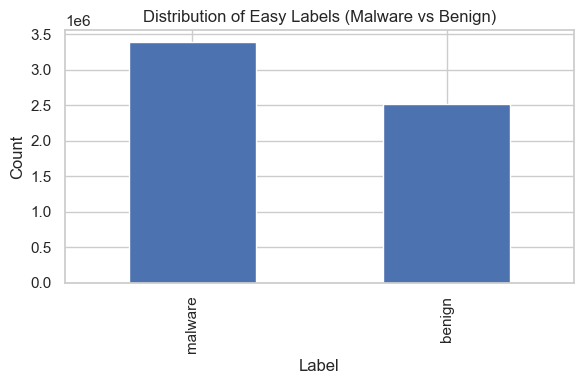

In [60]:
import matplotlib.pyplot as plt

label_counts = df_merged["easy_label"].value_counts()

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Easy Labels (Malware vs Benign)")
plt.tight_layout()
plt.show()


## 3. Model Training

### Split Data

Select Features + Target

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Select numeric feature columns only (drop raw_load and non-numerics)
feature_cols = df_merged.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns

# Remove frame_no and any label columns from features
feature_cols = [c for c in feature_cols if c not in ["frame_no"]]

X = df_merged[feature_cols]
y = df_merged["easy_label"]

# Train-test split using stratification for class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Name to model
models = {}

X_train.shape, X_test.shape


((4717889, 23), (1179473, 23))

### RandomForest 

Baseline Random Forest (handles imbalance automatically)

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced"
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

models["Random Forest"] = rf

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))

Random Forest Results:
              precision    recall  f1-score   support

      benign       0.99      0.98      0.99    502191
     malware       0.99      0.99      0.99    677282

    accuracy                           0.99   1179473
   macro avg       0.99      0.99      0.99   1179473
weighted avg       0.99      0.99      0.99   1179473



### XGboost

handles imbalance via scale_pos_weight
Computes the balancing weight

In [66]:
# Compute balancing weight

malware_count = (y_train == "malware").sum()
benign_count = (y_train == "benign").sum()

scale_pos_weight = benign_count / malware_count
scale_pos_weight

# Train

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    n_jobs=-1
)

xgb.fit(X_train, (y_train == "malware").astype(int))
xgb_pred = xgb.predict(X_test)

models["XGboost"] = xgb

print("XGBoost Results:")
print(classification_report((y_test == "malware").astype(int), xgb_pred))


XGBoost Results:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    502191
           1       0.94      0.94      0.94    677282

    accuracy                           0.93   1179473
   macro avg       0.93      0.93      0.93   1179473
weighted avg       0.93      0.93      0.93   1179473



### CatBoost 
works well with categorical + imbalance
Requires minimal preprocessing

In [67]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="Logloss",
    verbose=False,
    class_weights=[1, malware_count / benign_count]
)

cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)

models["CatBoost"] = cat

print("CatBoost Results:")
print(classification_report(y_test, cat_pred))

CatBoost Results:
              precision    recall  f1-score   support

      benign       0.98      0.81      0.89    502191
     malware       0.87      0.99      0.93    677282

    accuracy                           0.91   1179473
   macro avg       0.93      0.90      0.91   1179473
weighted avg       0.92      0.91      0.91   1179473



### KNN

must scale features

We also want to fill our NaNs with 0 because they arent accepted by KNN  
For port numbers (sport, dport, udp_sport, udp_dport): fill with 0 (meaning “unused for this protocol”)  
For lengths/checksums (udp_len, udp_chksum, payload_len): fill with 0  

In [ ]:


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn_model = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

models["KNN"] = knn_model

knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)



## 5. Evaluation

### Metrics Focus: Recall/Sensitivity
from our proposal "It is more prudent and valuable to stop all malware attacks than it is to ensure we don’t get false positives."* 

Therefore, we look closely at **Recall** for the Malware class.

--- Random Forest Results ---
              precision    recall  f1-score   support

      benign       0.91      1.00      0.95       181
     malware       0.00      0.00      0.00        19

    accuracy                           0.91       200
   macro avg       0.45      0.50      0.48       200
weighted avg       0.82      0.91      0.86       200



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

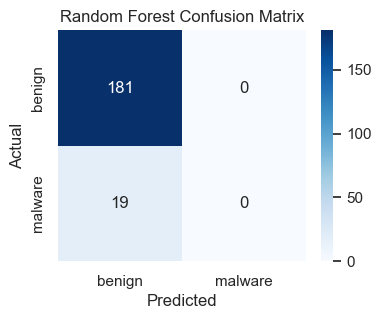

--- KNN Results ---
              precision    recall  f1-score   support

      benign       0.90      0.99      0.95       181
     malware       0.00      0.00      0.00        19

    accuracy                           0.90       200
   macro avg       0.45      0.50      0.47       200
weighted avg       0.82      0.90      0.86       200



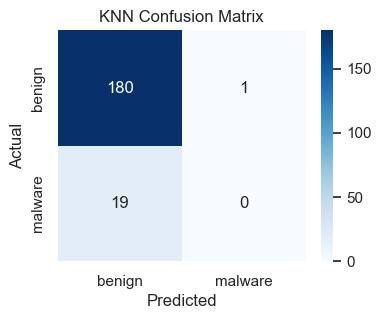

--- XGBoost Results ---
              precision    recall  f1-score   support

      benign       0.90      0.97      0.93       181
     malware       0.00      0.00      0.00        19

    accuracy                           0.88       200
   macro avg       0.45      0.48      0.47       200
weighted avg       0.82      0.88      0.84       200



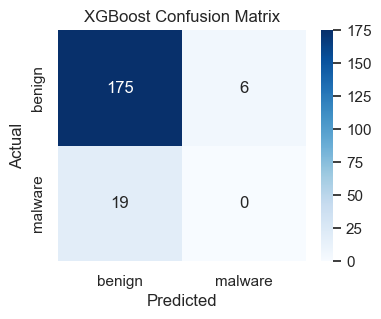

--- CatBoost Results ---
              precision    recall  f1-score   support

      benign       0.91      1.00      0.95       181
     malware       0.00      0.00      0.00        19

    accuracy                           0.91       200
   macro avg       0.45      0.50      0.48       200
weighted avg       0.82      0.91      0.86       200



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

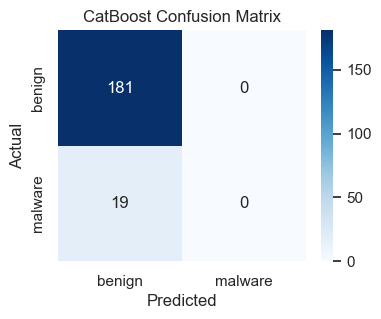

,Model,Accuracy,Recall (Sensitivity)
0,Random Forest,0.905,0.0
1,KNN,0.900,0.0
2,XGBoost,0.875,0.0
3,CatBoost,0.905,0.0


In [7]:
results = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    results.append({'Model': name, 'Accuracy': acc, 'Recall (Sensitivity)': rec})
    
    print(f"--- {name} Results ---")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Summary Table
results_df = pd.DataFrame(results)
results_df.sort_values(by='Recall (Sensitivity)', ascending=False)

## 6. Next Steps & Conclusion

- **Feature Importance:** Analyze which network features (from the netML dataset) contributed most to malware detection.
- **Hyperparameter Tuning:** Use GridSearch or RandomizedSearch to improve the best-performing model.
- **Ensembling:** If individual models perform well, consider the weighted ensemble approach mentioned in the proposal (AutoGluon or manual voting).

Maybe we should compare to the original netml results.